In [ ]:
%reset -f

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import time
import random
def print_np(x):
    print ("Type is %s" % (type(x)))
    print ("Shape is %s" % (x.shape,))
#     print ("Values are: \n%s" % (x))

In [ ]:
import os
import sys
sys.path.append('../')

In [ ]:
from model import UnicycleModel
from cost import UnicycleCost
from constraints import UnicycleConstraints
from scipy.integrate import solve_ivp
from matplotlib.patches import Ellipse
from utils.utils_alg import get_neighbor_vec,get_K_discrete
from utils.utils_plot import plot_traj,plot_traj_set,plot_state_input,plot_comparison

from trajopt import trajopt
from funlopt import funlopt
from Lipschitz import Lipschitz
from Scaling import TrajectoryScaling

from utils.utils_alg import get_sample_eta_w,propagate_model
import cvxpy as cvx
from scipy.integrate import solve_ivp



In [ ]:
N = 30
tf = 10
delT = tf/N

## obstacle setting

In [ ]:
def get_H_obs(rx,ry) :
    return np.diag([1/rx,1/ry])
# obstacle
c_list = []
H_list = []


c_list.append([1.8,0.3])
H_list.append(get_H_obs(0.5,0.5))

c_list.append([2*2/3,3.5])
H_list.append(get_H_obs(0.5,0.5))

c_list.append([4.2,0.7])
H_list.append(get_H_obs(0.5,0.5))
c_list.append([3.8,3.5])
H_list.append(get_H_obs(0.5,0.5))

c_list.append([10*2/3,0.5])
H_list.append(get_H_obs(0.5,0.5))
c_list.append([6.5,4])
H_list.append(get_H_obs(0.5,0.5))



c_list.append([4*2/3,1.7])
H_list.append(get_H_obs(0.5,0.5))
c_list.append([8*2/3,2.3])
H_list.append(get_H_obs(0.5,0.5))

c_list.append([0.5,2])
H_list.append(get_H_obs(0.5,0.5))
c_list.append([8,2.3])
H_list.append(get_H_obs(0.5,0.5))


## initial and final conditions 

In [ ]:
myModel = UnicycleModel.unicycle2('unicycle','numeric_central')

ix = myModel.ix
iu = myModel.iu
iw = myModel.iw
iq = myModel.iq
ip = myModel.ip

C = myModel.C
D = myModel.D
E = myModel.E
G = myModel.G

myCost = UnicycleCost.unicycle('Hello',ix,iu,N,weight_factor_omega=1)
myConst = UnicycleConstraints.UnicycleConstraints('Hello',ix,iu,vmax=1.5,wmax=1.0,wmin=-1.0)
myConst.set_obstacle(c_list,H_list)



In [90]:
xi = np.zeros(3)
xi[0] = 0.0
xi[1] = 0.0 
xi[2] = 0.0

xf = np.zeros(3)
xf[0] = 8.0
xf[1] = 4.0
xf[2] = np.deg2rad(30)

Qini = np.diag([0.2**2,0.2**2,np.deg2rad(10)**2])
Qf = np.diag([0.2**2,0.2**2,np.deg2rad(10)**2])

x0 = np.zeros((N+1,ix))
for i in range(N+1) :
    x0[i] = (N-i)/N * xi + i/N * xf
u0 = np.zeros((N+1,iu))

In [91]:
A,B,s,z,x_prop_n = myModel.diff_discrete_zoh(x0[0:N,:],u0[0:N,:],delT,tf) 
S = np.eye(ix)
R = 1*np.eye(iu)
K0 = get_K_discrete(A,B,S,R,S,N,ix,iu)
Q0 = np.tile(np.diag([0.2**2,0.2**2,np.deg2rad(10)**2]),(N+1,1,1))
Y0 = K0@Q0[:N]
betahat = np.ones(N+1)

In [92]:
x_max = np.array([10,10,np.pi])
x_min = np.zeros(ix)

u_max = np.array([5,5]) 
u_min = np.zeros(iu)

traj_scaling = TrajectoryScaling(x_min,x_max,u_min,u_max,tf)

x_max = np.array([1,1,np.pi])
x_min = np.zeros(ix)

u_max = np.array([5,5]) 
u_min = np.zeros(iu)

funl_scaling = TrajectoryScaling(x_min,x_max,u_min,u_max,tf)
funl_scaling.snu_p = 1

In [93]:
traj_solver= trajopt('unicycle',N,tf,10,myModel,myCost,myConst,Scaling=traj_scaling,
              w_c=1,w_vc=1e2,w_tr=1e0,tol_vc=1e-6,tol_tr=1e-4,tol_dyn=1e-3,verbosity=True)

Is DPP?  True


In [94]:
_,_,xnom,unom,_,total_num_iter,_,_,_,_,history_nom = traj_solver.run(x0,u0,xi,xf)
tnom = np.array(range(N+1))*delT

┌──────────────────────────────────────────────────────────────────────────────────────────────┐

│                                              ..:: SCP ::..                                   │

├──────┬───────────┬──────────┬─────────┬───────────┬────────────┬─────────┬─────────┬─────────┤

│ iter │  total    │ final    │ input   │     -     │ total cost │ vc      │ tr      │ dyn     │

│      │  cost     │ time [s] │ energy  │     -     │ reduction  │ (log10) │         │         │

├──────┼───────────┼──────────┼─────────┼───────────┼────────────┼─────────┼─────────┼─────────┤

│1     │40.633     │10.000    │21.4     │0          │-40.6       │0(-0.74 )│0(0.872 )│0(0.633 )│
│2     │24.732     │10.000    │24.4     │0          │15.9        │1(-9.69 )│0(0.326 )│0(0.033 )│
│3     │25.687     │10.000    │25.7     │0          │-0.955      │1(-10.04)│0(0.014 )│0(0.003 )│
│4     │25.636     │10.000    │25.6     │0          │0.0503      │1(-10.26)│0(0.001 )│1(0.000 )│
│5     │25.618     │10.0

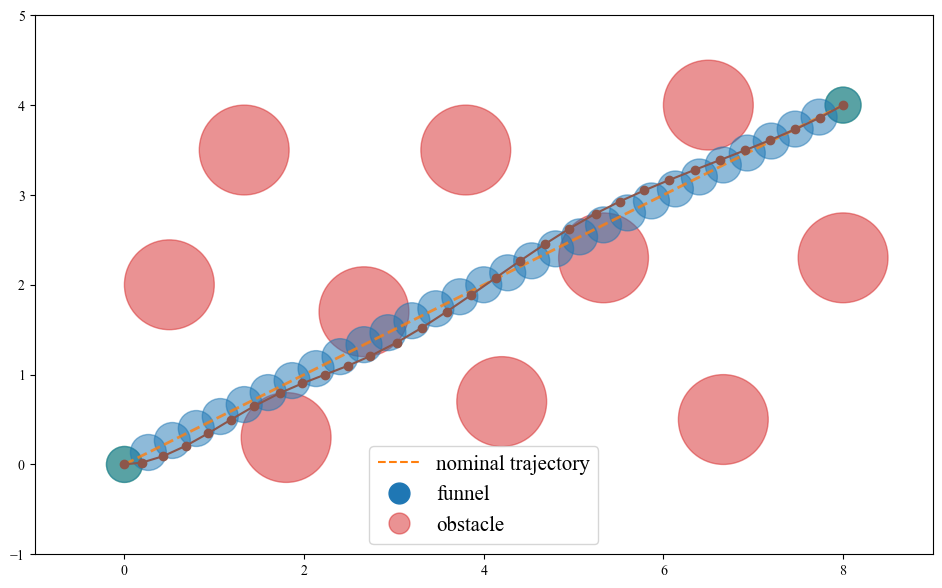

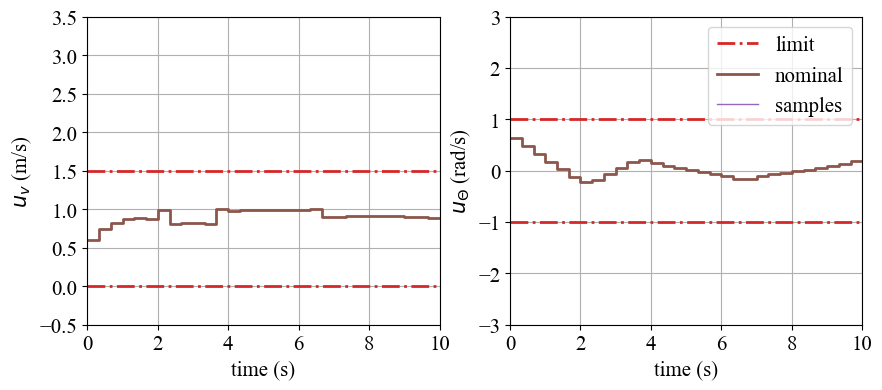

In [95]:
fS = 15
plt.figure(0,figsize=(15,7))
plot_traj_set(x0,u0,c_list,H_list,Q0,xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt)
plt.plot(xnom[:,0],xnom[:,1],'o-',color='tab:brown',label='traj w/o funnel')
plt.axis([-1.0, 9.0, -1.0, 5.0])
plt.figure(1,figsize=(10,4))
plt.subplot(121)
plt.plot(tnom, unom[:,0]*0+myConst.vmax,'-.',color='tab:red',alpha=1.0,linewidth=2.0,label='limit')
plt.plot(tnom, unom[:,0]*0+myConst.vmin,'-.',color='tab:red',alpha=1.0,linewidth=2.0)
plt.step(tnom, [*unom[:N,0],unom[N-1,0]],'-',color='tab:brown',alpha=1.0,where='post',linewidth=2.0,label='nominal')
plt.plot(1e3, 1e3,'-',color='tab:purple',alpha=1.0,linewidth=1.0,label='samples')
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('$u_v$ (m/s)', fontsize = fS)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis([0.0, tf, -0.5, 3.5])
plt.grid(True)

plt.subplot(122)
plt.plot(tnom, unom[:,1]*0+myConst.wmax,'-.',color='tab:red',alpha=1.0,linewidth=2.0)
plt.plot(tnom, unom[:,1]*0+myConst.wmin,'-.',color='tab:red',alpha=1.0,linewidth=2.0,label='limit')
plt.step(tnom, [*unom[:N,1],unom[N-1,1]],'-',color='tab:brown',alpha=1.0,where='post',linewidth=2.0,label='nominal')
plt.plot(1e3, 1e3,'-',color='tab:purple',alpha=1.0,linewidth=1.0,label='samples')
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('$u_{\Theta}$ (rad/s)', fontsize = fS)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis([0.0, tf, -3, 3])
plt.legend(fontsize=fS)
plt.rcParams["font.family"] = "Times New Roman"
plt.grid(True)

## run

In [98]:
total_iter = 40
max_iter_trajopt = 1

tol_funl = 1e-8
tol_traj = 1e-8
tol_vc = 1e-8
tol_dyn = 1e-8

alpha = 0.99
lambda_mu = 0.2
funl_w_tr = 1e-6

traj_solver= trajopt('unicycle',N,tf,max_iter_trajopt,myModel,myCost,myConst,Scaling=traj_scaling,
              w_c=1,w_vc=1e3,w_tr=1e-1,tol_vc=1e-6,tol_tr=1e-4,tol_dyn=1e-3,verbosity=False)

funl_solver = funlopt('unicycle',ix,iu,iq,ip,iw,N,funl_scaling,
                      alpha=alpha,
                      lambda_mu=lambda_mu,
                      w_tr=funl_w_tr,
                      flag_nonlinearity=True)
funl_solver.cvx_initialize(Qini,Qf,num_const_state=len(c_list),num_const_input=4)
# funl_solver.cvx_initialize(Qini,Qf,num_const_state=0,num_const_input=0)
lip_estimator = Lipschitz('unicycle',ix,iu,iq,ip,iw,N,num_sample=100,flag_uniform=True)

from jointsynthesis import jointsynthesis
JS = jointsynthesis(myModel,traj_solver,funl_solver,lip_estimator,total_iter,
                   tol_traj,tol_funl,tol_vc,tol_dyn,verbosity=True)

Is DPP?  True
nonlinear funnel
Is DPP?  True


In [99]:
history = JS.run(xi,xf,x0,u0,Q0,Y0,K0)

|iter| traj_cost | funl_cost |   vc   |   Delta_T   |   Delta_F   | e_prop  |gamma diff|
|    |           |           | log10  |   log10     |   log10     | log10   |          |
|1   |25.966     |3.823      |-0.621(0)|1.48      (0)|2.57      (0)|0.387(0)|0.76712370|
|2   |33.068     |2.805      |-11  (1)|1.38      (0)|1.42      (0)|0.128(0)|0.29112218|
|3   |29.999     |2.411      |-12.4(1)|0.789     (0)|0.934     (0)|-0.434(0)|0.23247660|
|4   |29.729     |2.322      |-11.5(1)|-0.214    (0)|0.0236    (0)|-1.451(0)|0.07012519|
|5   |29.662     |2.296      |-11.7(1)|-0.963    (0)|-0.981    (0)|-2.348(0)|0.02765011|
|6   |29.555     |2.299      |-11.7(1)|-1.62     (0)|-1.38     (0)|-2.899(0)|0.01399048|
|7   |29.524     |2.303      |-11.7(1)|-2.4      (0)|-1.95     (0)|-3.738(0)|0.00821958|
|8   |29.509     |2.308      |-11.7(1)|-3.19     (0)|-2.4      (0)|-4.522(0)|0.00347747|
|9   |29.505     |2.311      |-11.7(1)|-4.03     (0)|-2.92     (0)|-5.613(0)|0.00207751|
|10  |29.503     |2.31

In [100]:
history[0]['gamma']

array([0.01880913, 0.01866809, 0.01916285, 0.02479114, 0.03251492,
       0.03576636, 0.03578925, 0.0261328 , 0.01831025, 0.01561144,
       0.03587389, 0.01835802, 0.01546267, 0.01540632, 0.01543455,
       0.01918786, 0.02681245, 0.03472521, 0.03599396, 0.03600085,
       0.03600354, 0.03330796, 0.02691559, 0.02157836, 0.01808946,
       0.0364396 , 0.03202814, 0.02725064, 0.0217    , 0.01499842])

In [101]:
del_traj_list = [history[i]['traj_diff'] for i in range(len(history))]
del_funl_list = [history[i]['funl_diff'] for i in range(len(history))]
vc_list = [history[i]['vc'] for i in range(len(history))]
dyn_error_list = [history[i]['dyn_error'] for i in range(len(history))]

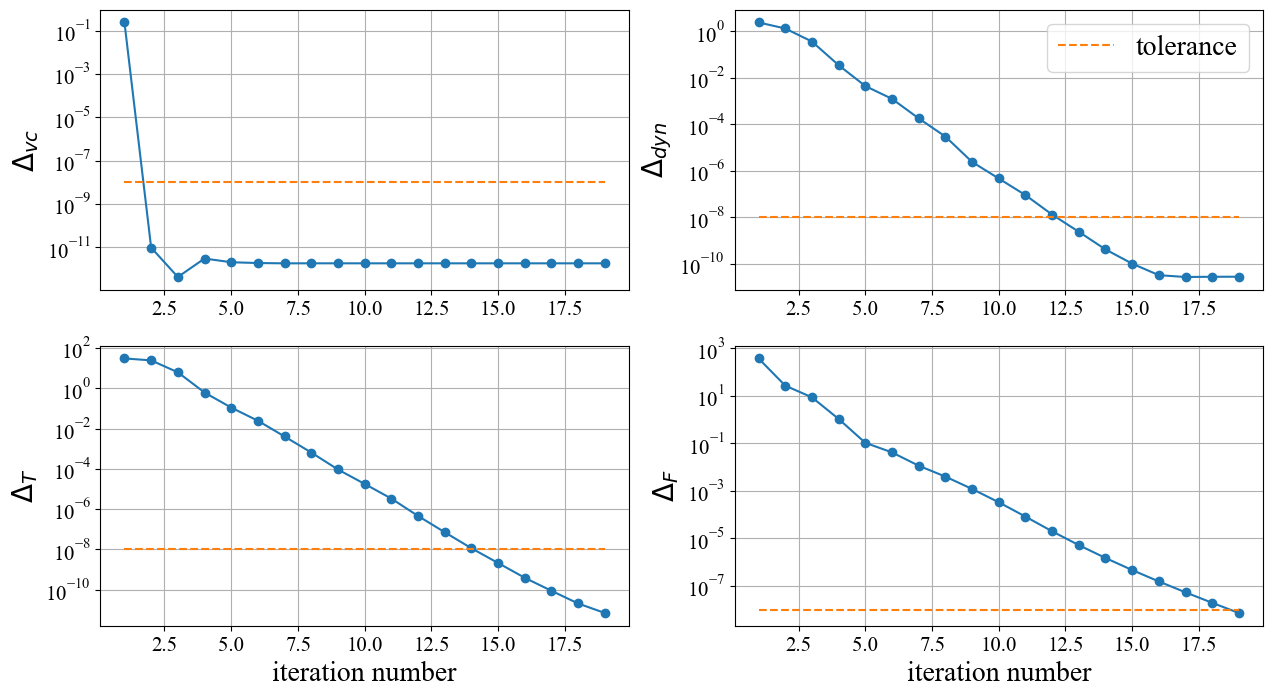

In [105]:
i_index = np.array([i+1 for i in range(len(history))])
fS = 20
plt.figure(figsize=(15,8))
plt.subplot(221)
plt.plot(i_index,vc_list,'o-')
plt.plot(i_index,i_index*0+tol_vc,'--')
# plt.xlabel('iteration number',fontsize=fS,fontname='Times New Roman')
plt.ylabel(r'$\Delta_{vc}$',fontsize=fS,fontname='Times New Roman')
plt.yscale('log')
# plt.ylim([10**(-6), 10**(4)])
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(222)
plt.plot(i_index,dyn_error_list,'o-')
plt.plot(i_index,i_index*0+tol_dyn,'--',label='tolerance')
# plt.xlabel('iteration number',fontsize=fS,fontname='Times New Roman')
plt.ylabel(r'$\Delta_{dyn}$',fontsize=fS,fontname='Times New Roman')
plt.yscale('log')
# plt.ylim([10**(-6), 10**(4)])
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=fS)


plt.subplot(223)
plt.plot(i_index,del_traj_list,'o-')
plt.plot(i_index,i_index*0+tol_traj,'--')
plt.xlabel('iteration number',fontsize=fS,fontname='Times New Roman')
plt.ylabel(r'$\Delta_T$',fontsize=fS,fontname='Times New Roman')
plt.yscale('log')
# plt.ylim([10**(-6), 10**(4)])
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(224)
plt.plot(i_index,del_funl_list,'o-')
plt.plot(i_index,i_index*0+tol_funl,'--')
plt.xlabel('iteration number',fontsize=fS,fontname='Times New Roman')
plt.ylabel(r'$\Delta_F$',fontsize=fS,fontname='Times New Roman')
plt.yscale('log')
# plt.ylim([10**(-6), 10**(4)])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.rcParams["font.family"] = "Times New Roman"
plt.grid(True)


plt.savefig('../images/unicycle/convergence_result.pdf')

# Computational time

In [106]:
time_derivs = []
time_trajopt = []
time_funlopt = []
time_lipschitz = []

for his in history[1:] :
    time_derivs.append(his['t_derivs'])
    time_trajopt.append(his['t_trajopt'])
    time_funlopt.append(his['t_funlopt'])
    time_lipschitz.append(his['t_Lipschitz'])
def mean_list(l) :
    return sum(l)/len(l)
mean_derivs = mean_list(time_derivs)
mean_trajopt = mean_list(time_trajopt)
mean_funlopt = mean_list(time_funlopt)
mean_lipschitz = mean_list(time_lipschitz)
print("mean_derivs",mean_derivs)
print("mean_trajopt",mean_trajopt)
print("mean_funlopt",mean_funlopt)
print("mean_lipschitz",mean_lipschitz)

mean_derivs 0.005698654386732314
mean_trajopt 0.025189439455668133
mean_funlopt 0.6743259165022109
mean_lipschitz 0.9065823687447442


# Evaluate the generated traj and funl

In [107]:
from utils.utils_alg import forward_full_with_K,get_sample_trajectory
import scipy

In [108]:
xbar = history[-1]['x']
ubar = history[-1]['u']
Qbar = history[-1]['Q']
Ybar = history[-1]['Y']
Kbar = history[-1]['K']
gammabar = history[-1]['gamma']

(-1.0, 9.0, -1.0, 5.0)

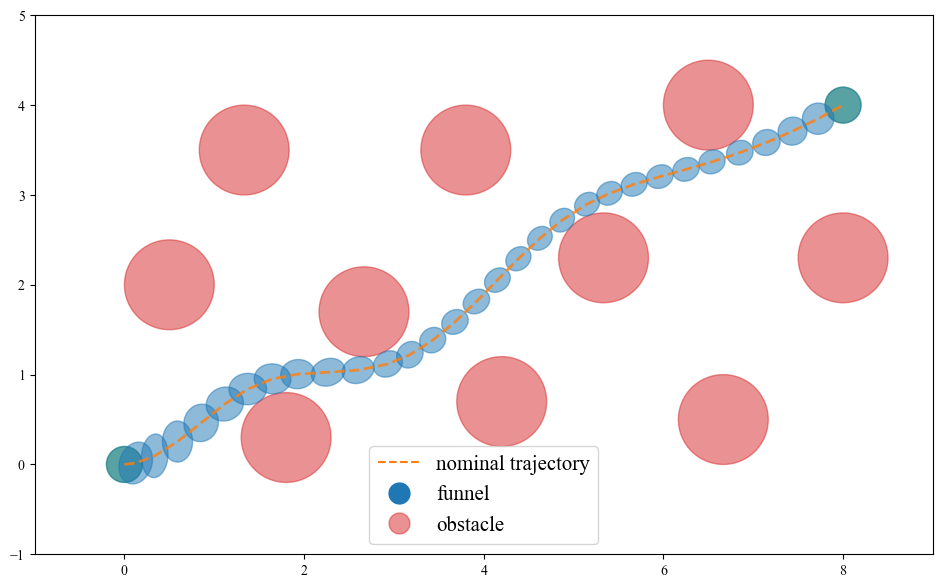

In [109]:
fS = 15
plt.figure(0,figsize=(15,7))
plot_traj_set(xbar,ubar,c_list,H_list,Qbar,xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt)
plt.legend(fontsize=fS)
plt.rcParams["font.family"] = "Times New Roman"
plt.axis([-1.0, 9.0, -1.0, 5.0])

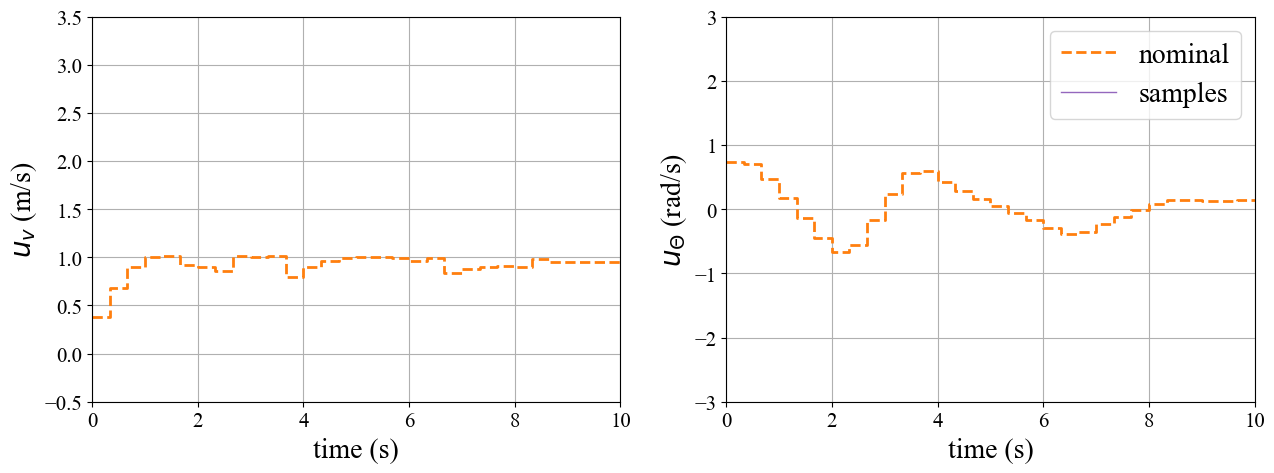

In [110]:

fS = 20
plt.figure(0,figsize=(15,5))
alpha = 1.0
t_index = np.array(range(N+1))*delT
plt.subplot(121)
plt.step(t_index, [*ubar[:N,0],ubar[N-1,0]],'--',color='tab:orange',alpha=1.0,where='post',linewidth=2.0,label='nominal')
plt.plot(1e3, 1e3,'-',color='tab:purple',alpha=1.0,linewidth=1.0,label='samples')
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('$u_v$ (m/s)', fontsize = fS)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis([0.0, tf, -0.5, 3.5])
plt.grid(True)
plt.subplot(122)
plt.step(t_index, [*ubar[:N,1],ubar[N-1,1]],'--',color='tab:orange',alpha=1.0,where='post',linewidth=2.0,label='nominal')
plt.plot(1e3, 1e3,'-',color='tab:purple',alpha=1.0,linewidth=1.0,label='samples')
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('$u_{\Theta}$ (rad/s)', fontsize = fS)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis([0.0, tf, -3, 3])
plt.legend(fontsize=fS)
plt.rcParams["font.family"] = "Times New Roman"
plt.grid(True)


# comparison with linear case

In [111]:
traj_solver= trajopt('unicycle',N,tf,max_iter_trajopt,myModel,myCost,myConst,Scaling=traj_scaling,
              w_c=1,w_vc=1e3,w_tr=1e-1,tol_vc=1e-6,tol_tr=1e-4,tol_dyn=1e-3,verbosity=False)

funl_solver = funlopt('unicycle',ix,iu,iq,ip,iw,N,funl_scaling,
                      alpha=alpha,
                      lambda_mu=lambda_mu,
                      w_tr=funl_w_tr,
                      flag_nonlinearity=False)
# funl_solver.cvx_initialize(Qini,Qf)
funl_solver.cvx_initialize(Qini,Qf,num_const_state=len(c_list),num_const_input=4)
lip_estimator = Lipschitz('unicycle',ix,iu,iq,ip,iw,N,num_sample=100,flag_uniform=True)

from jointsynthesis import jointsynthesis
JS = jointsynthesis(myModel,traj_solver,funl_solver,lip_estimator,total_iter,
                   tol_traj,tol_funl,tol_vc,tol_dyn,verbosity=True)

Is DPP?  True
linear funnel
Is DPP?  True


In [112]:
history_linear = JS.run(xi,xf,x0,u0,Q0,Y0,K0)

|iter| traj_cost | funl_cost |   vc   |   Delta_T   |   Delta_F   | e_prop  |gamma diff|
|    |           |           | log10  |   log10     |   log10     | log10   |          |
|1   |25.966     |1.820      |-0.621(0)|1.48      (0)|2.64      (0)|0.387(0)|0.76712370|
|2   |26.881     |1.732      |-12.2(1)|1.22      (0)|1.66      (0)|0.034(0)|0.48623234|
|3   |28.032     |1.703      |-12.7(1)|0.183     (0)|0.694     (0)|-1.148(0)|0.09646919|
|4   |27.973     |1.709      |-12.5(1)|-1.02     (0)|-0.588    (0)|-2.390(0)|0.03868485|
|5   |27.961     |1.708      |-12.1(1)|-2.22     (0)|-1.73     (0)|-3.554(0)|0.00937616|
|6   |27.957     |1.708      |-12.7(1)|-3.23     (0)|-2.54     (0)|-4.559(0)|0.00213898|
|7   |27.957     |1.707      |-12.5(1)|-3.97     (0)|-3.14     (0)|-5.210(0)|0.00092203|
|8   |27.957     |1.707      |-12.5(1)|-4.86     (0)|-4.01     (0)|-6.231(0)|0.00046457|
|9   |27.957     |1.707      |-12.5(1)|-5.65     (0)|-4.77     (0)|-6.915(0)|0.00015864|
|10  |27.957     |1.70

In [113]:
xbar_linear = history_linear[-1]['x']
ubar_linear = history_linear[-1]['u']
Qbar_linear = history_linear[-1]['Q']
Ybar_linear = history_linear[-1]['Y']
Kbar_linear = history_linear[-1]['K']

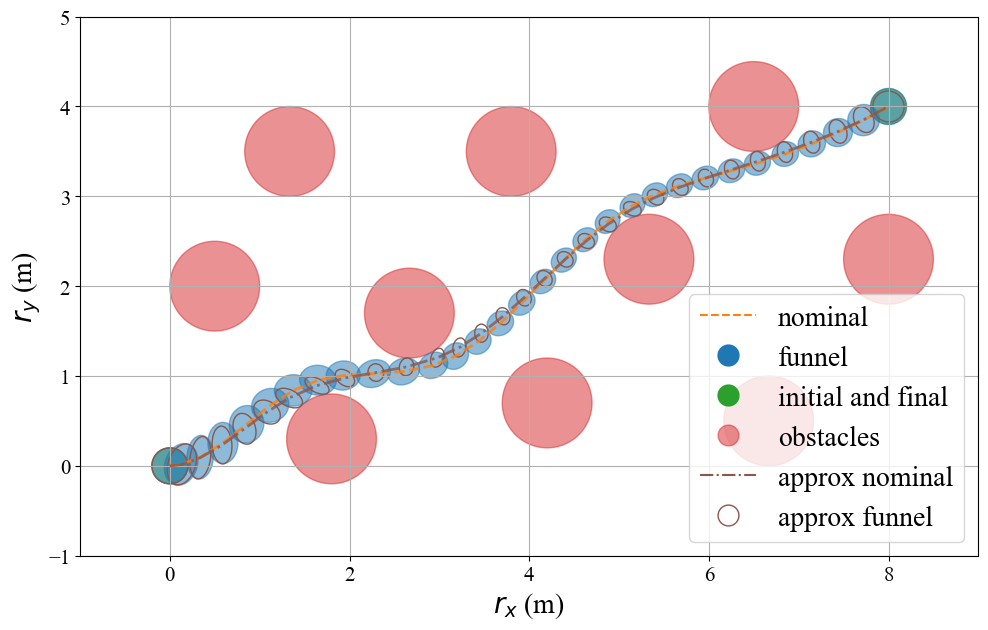

In [115]:
fS = 20
plt.figure(0,figsize=(15,7))
plot_comparison(xbar,xbar_linear,c_list,H_list,Qbar,Qbar_linear,xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt,fS=fS)
plt.legend(fontsize=fS)
plt.grid(True)
plt.rcParams["font.family"] = "Times New Roman"
plt.axis([-1.0, 9.0, -1.0, 5.0])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('../images/unicycle/traj_result.pdf')

# Sample from initial set

In [116]:
x0_sample = []
num_sample = 100
for i in range(num_sample) :
    z = np.random.randn(ix)
    z = z / np.linalg.norm(z)
    # z = np.array([0,1,0])
    x_s = xbar[0] + scipy.linalg.sqrtm(Qbar[0])@z
    x0_sample.append(x_s)
    
tsam,xsam,usam,wsam,xsamp = get_sample_trajectory(xi,x0_sample,xbar,ubar,Qbar,Ybar,myModel,N,ix,iu,iw,delT,
                                            flag_noise=True)

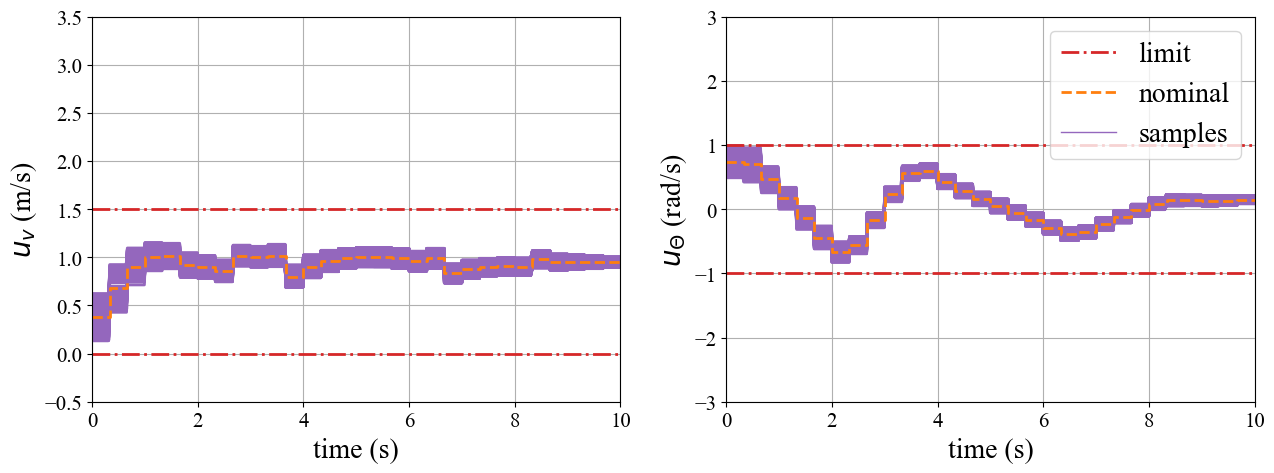

In [123]:
fS = 20
plt.figure(0,figsize=(15,5))
alpha = 1.0
t_index = np.array(range(N+1))*delT
for i in range(num_sample) :
    tsam_e = tsam[i]
    xsam_e = xsam[i]
    usam_e = usam[i]
#     plot_state_input(tsam_e,xsam_e,usam_e,None,None,N,delT,alpha,plt,flag_step=False)

    plt.subplot(121)
    plt.plot(tsam_e, usam_e[:,0],color='tab:purple',alpha=alpha,linewidth=2.0)
    plt.subplot(122)
    plt.plot(tsam_e, usam_e[:,1],color='tab:purple',alpha=alpha,linewidth=2.0)
plt.subplot(121)
plt.plot(tsam_e, usam_e[:,0]*0+myConst.vmax,'-.',color='tab:red',alpha=1.0,linewidth=2.0,label='limit')
plt.plot(tsam_e, usam_e[:,0]*0+myConst.vmin,'-.',color='tab:red',alpha=1.0,linewidth=2.0)
plt.step(t_index, [*ubar[:N,0],ubar[N-1,0]],'--',color='tab:orange',alpha=1.0,where='post',linewidth=2.0,label='nominal')
plt.plot(1e3, 1e3,'-',color='tab:purple',alpha=1.0,linewidth=1.0,label='samples')
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('$u_v$ (m/s)', fontsize = fS)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis([0.0, tf, -0.5, 3.5])
plt.grid(True)
plt.subplot(122)
plt.plot(tsam_e, usam_e[:,1]*0+myConst.wmax,'-.',color='tab:red',alpha=1.0,linewidth=2.0)
plt.plot(tsam_e, usam_e[:,1]*0+myConst.wmin,'-.',color='tab:red',alpha=1.0,linewidth=2.0,label='limit')
plt.step(t_index, [*ubar[:N,1],ubar[N-1,1]],'--',color='tab:orange',alpha=1.0,where='post',linewidth=2.0,label='nominal')
plt.plot(1e3, 1e3,'-',color='tab:purple',alpha=1.0,linewidth=1.0,label='samples')
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('$u_{\Theta}$ (rad/s)', fontsize = fS)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis([0.0, tf, -3, 3])
plt.legend(fontsize=fS)
plt.rcParams["font.family"] = "Times New Roman"
plt.grid(True)
plt.savefig('../images/unicycle/input_result.pdf')


(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.]),
 [Text(0, -1.0, '−1'),
  Text(0, 0.0, '0'),
  Text(0, 1.0, '1'),
  Text(0, 2.0, '2'),
  Text(0, 3.0, '3'),
  Text(0, 4.0, '4'),
  Text(0, 5.0, '5')])

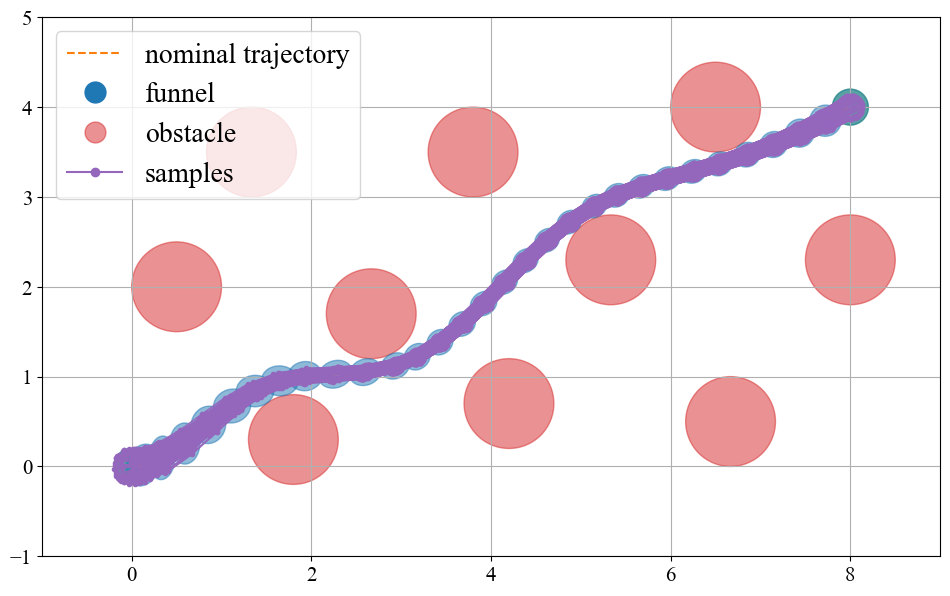

In [118]:
fS = 20
plt.figure(0,figsize=(15,7))
plot_traj_set(xbar,ubar,c_list,H_list,Qbar,xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt,flag_label=True,fS=fS)
# for xsam_e in xsam :
for xsam_e in xsamp :
    plt.plot(xsam_e[:,0], xsam_e[:,1],'o-',markersize=3.0, linewidth=1.0,alpha=1.0,color='tab:purple')
plt.plot(1e3,1e3,'o-',color='tab:purple',label='samples')
# plt.plot(xnom[:,0],xnom[:,1],'-.',color='tab:brown',label='traj w/o funnel')
plt.legend(fontsize=fS)
plt.grid(True)
plt.rcParams["font.family"] = "Times New Roman"
plt.axis([-1.0, 9.0, -1.0, 5.0])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig('../images/traj_result_new.pdf')

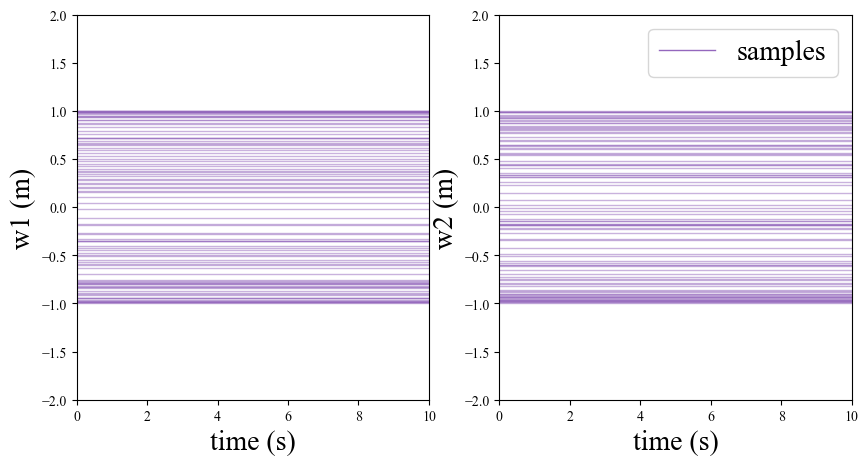

In [119]:
fS = 20
plt.figure(0,figsize=(10,5))
alpha = 0.5
t_index = np.array(range(N+1))*delT
for i in range(num_sample) :
    tsam_e = tsam[i]
    xsam_e = xsam[i]
    wsam_e = wsam[i]
#     plot_state_input(tsam_e,xsam_e,usam_e,None,None,N,delT,alpha,plt,flag_step=False)
    plt.subplot(121)
    plt.plot(tsam_e, wsam_e[:,0],color='tab:purple',alpha=alpha,linewidth=1.0)
    plt.subplot(122)
    plt.plot(tsam_e, wsam_e[:,1],color='tab:purple',alpha=alpha,linewidth=1.0)
plt.subplot(121)
plt.plot(1e3, 1e3,'-',color='tab:purple',alpha=1.0,linewidth=1.0,label='samples')
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('w1 (m)', fontsize = fS)
plt.axis([0.0, tf, -2, 2])
plt.subplot(122)
plt.plot(1e3, 1e3,'-',color='tab:purple',alpha=1.0,linewidth=1.0,label='samples')
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('w2 (m)', fontsize = fS)
plt.axis([0.0, tf, -2, 2])
plt.legend(fontsize=fS)
plt.rcParams["font.family"] = "Times New Roman"
# plt.savefig('../images/disturbance.pdf')

(3.7, 5.7, 1.5, 3.5)

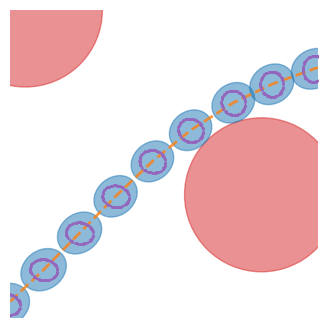

In [120]:
fS = 15
plt.figure(0,figsize=(4,4))
plot_traj_set(xbar,ubar,c_list,H_list,Qbar,xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt,flag_label=False)
for xsam_e in xsamp :
    plt.plot(xsam_e[:,0], xsam_e[:,1],'o',markersize=1.0, linewidth=1.0,alpha=1.0,color='tab:purple')
plt.plot(1e3,1e3,'o-',color='tab:purple',label='samples')
# plt.plot(xnom[:,0],xnom[:,1],'-.',color='tab:brown',label='traj w/o funnel')
# plt.legend(fontsize=fS)
plt.grid(True)
plt.rcParams["font.family"] = "Times New Roman"
plt.axis([3.7, 5.7, 1.5, 3.5])
plt.axis('off')
# plt.savefig('../images/traj_result_new_expansion.pdf')

(-1.0, 1.0, -1.0, 1.0)

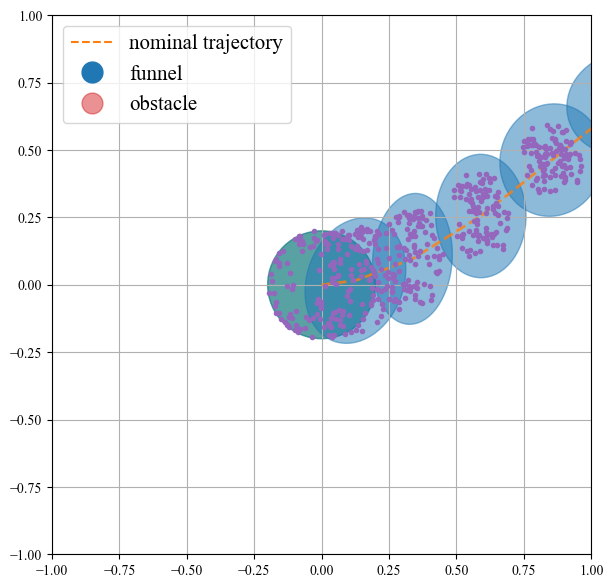

In [121]:
fS = 15
plt.figure(0,figsize=(15,7))
plot_traj_set(xbar,ubar,c_list,H_list,Qbar,xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt,flag_label=True)
for xsam_e in xsamp :
    plt.plot(xsam_e[:,0], xsam_e[:,1],'o',markersize=3.0, linewidth=1.0,alpha=1.0,color='tab:purple')
#     plt.plot(xsam_e[1,0], xsam_e[1,1],'o',markersize=3.0, linewidth=1.0,alpha=1.0,color='tab:purple')
plt.plot(1e3,1e3,'o-',color='tab:purple',label='samples')
# plt.plot(xnom[:,0],xnom[:,1],'-.',color='tab:brown',label='traj w/o funnel')
# plt.legend(fontsize=fS)
plt.grid(True)
plt.rcParams["font.family"] = "Times New Roman"
plt.axis([-1, 1, -1, 1])
# plt.savefig('../images/traj_result.pdf')

(7.0, 9.0, 3.0, 5.0)

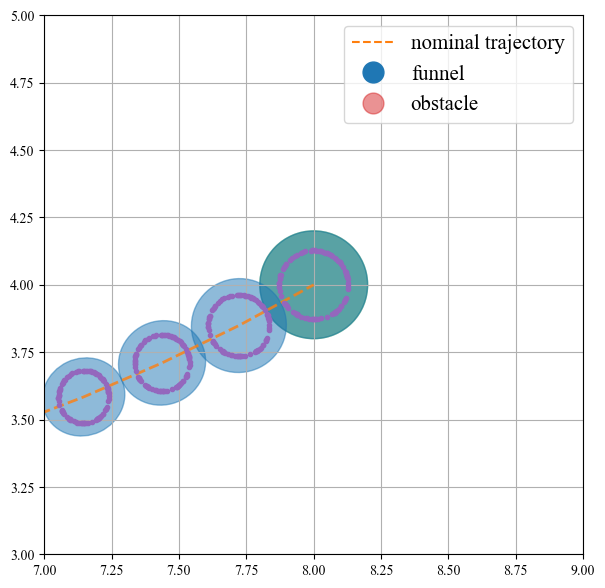

In [122]:
fS = 15
plt.figure(0,figsize=(15,7))
plot_traj_set(xbar,ubar,c_list,H_list,Qbar,xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt,flag_label=True)
for xsam_e in xsamp :
    plt.plot(xsam_e[:,0], xsam_e[:,1],'o',markersize=3.0, linewidth=1.0,alpha=1.0,color='tab:purple')
#     plt.plot(xsam_e[1,0], xsam_e[1,1],'o',markersize=3.0, linewidth=1.0,alpha=1.0,color='tab:purple')
plt.plot(1e3,1e3,'o-',color='tab:purple',label='samples')
# plt.plot(xnom[:,0],xnom[:,1],'-.',color='tab:brown',label='traj w/o funnel')
# plt.legend(fontsize=fS)
plt.grid(True)
plt.rcParams["font.family"] = "Times New Roman"
plt.axis([7, 9, 3, 5])
# plt.savefig('../images/traj_result.pdf')

# sample from approx funnel

In [125]:
x0_sample = []
for i in range(num_sample) :
    z = np.random.randn(ix)
    z = z / np.linalg.norm(z)
    x_s = xbar_linear[0] + scipy.linalg.sqrtm(Qbar_linear[0])@z
    x0_sample.append(x_s)
tsam_linear,xsam_linear,usam_linear,wsam_linear,xsamp_linear = get_sample_trajectory(xi,x0_sample,
                                                                    xbar_linear,ubar_linear,
                                                                    Qbar_linear,Ybar_linear,myModel,N,ix,iu,iw,delT,
                                                                    flag_noise=True)

there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation


In [126]:
def get_radii_list(xsamp,xbar,Qbar) :
    radii_list = []
    for x in xsamp :
        radii = np.zeros(N+1)
        for i in range(N+1) :
            radii[i] = (x[i]-xbar[i]).T@np.linalg.inv(Qbar[i])@(x[i]-xbar[i])
            if radii[i] > 1 + 1e-8 :
                print("invariance violation",radii[i])
        radii_list.append(radii)
    return radii_list
radii_list = get_radii_list(xsamp,xbar,Qbar)
radii_list_linear = get_radii_list(xsamp_linear,xbar_linear,Qbar_linear)

invariance violation 1.0101719327666645
invariance violation 1.0057813748909956
invariance violation 1.0078807211597443
invariance violation 1.0088764120719527
invariance violation 1.0208168800712485
invariance violation 1.0208525625477087
invariance violation 1.019001129190584
invariance violation 1.0252465014739505
invariance violation 1.0439932099526656
invariance violation 1.0406636143087196
invariance violation 1.0015175583213887
invariance violation 1.019618303772084
invariance violation 1.0224138919697021
invariance violation 1.0042625030684886
invariance violation 1.0019275084327848
invariance violation 1.0117862484838953
invariance violation 1.0114186629398572
invariance violation 1.005124522990786


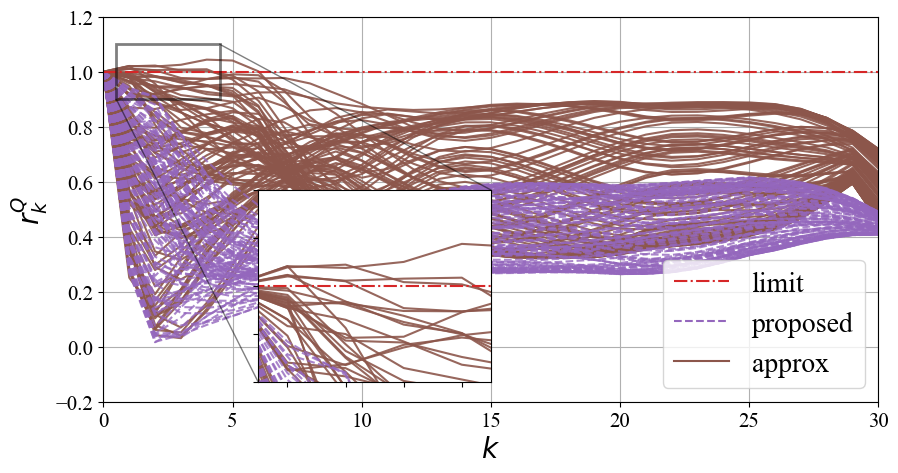

In [128]:
fS = 20
idx_plot = [i for i in range(N+1)]
fig, ax = plt.subplots(figsize=[10, 5])
for radii in radii_list_linear :
    ax.plot(idx_plot,radii,color='tab:brown',alpha=0.9)
for radii in radii_list :
    ax.plot(idx_plot,radii,'--',color='tab:purple',alpha=0.8)
ax.plot(idx_plot,radii*0+1,'-.',color='tab:red',alpha=1.0,label='limit')
plt.xlabel('$k$', fontsize = fS)
plt.ylabel('$r^Q_k$', fontsize = fS)
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis([0,30,-0.2,1.2])
plt.plot(1e3,1e3,'--',color='tab:purple',alpha=1.0,label='proposed')
plt.plot(1e3,1e3,color='tab:brown',alpha=1.0,label='approx')
plt.legend(fontsize=fS)
# axins = ax.inset_axes([5, 15, 0.0, 0.6])
axins = ax.inset_axes([0.2, 0.05, 0.3, 0.5])

for radii in radii_list_linear :
    axins.plot(idx_plot,radii,color='tab:brown',alpha=0.9)
for radii in radii_list :
    axins.plot(idx_plot,radii,'--',color='tab:purple',alpha=0.8)
axins.plot(idx_plot,radii*0+1,'-.',color='tab:red',alpha=1.0,label='limit')

axins.set_xlim(0.5, 4.5)
axins.set_ylim(0.9, 1.1)
axins.set_xticklabels([])
axins.set_yticklabels([])
ax.indicate_inset_zoom(axins, edgecolor="black",linewidth=2.0)
plt.grid(True)
plt.rcParams["font.family"] = "Times New Roman"
plt.savefig('../images/unicycle/invariance_result.pdf')

# Search the case of violating the invariance

In [ ]:
from scipy.integrate import solve_ivp
def dfdt(t,x,u,w) :
    return np.squeeze(myModel.forward_uncertain(x,u,w))

num_test = 100
for i in range(num_test) :
    z = np.random.randn(ix)
    z = z / np.linalg.norm(z)
    x_s = xbar[0] + scipy.linalg.sqrtm(Qbar[0])@z
    
    u = ubar[0] + Kbar[0]@(x_s-xbar[0])
    
    z = np.random.randn(iw)
    w = z / np.linalg.norm(z)
#     w = np.array([1,0])
    
    sol = solve_ivp(dfdt,(0,delT),x_s,args=(u,w),max_step=delT/10,method='RK45',rtol=1e-6,atol=1e-10)
    
    xnew = sol.y[:,-1]
    radi_next = (xnew-xbar[1]).T@np.linalg.inv(Qbar[1])@(xnew-xbar[1])
    if radi_next > 1 :
        print("found!",radi_next)
        break
    if i == num_test - 1 :
        print("no case")
        
    
    

In [ ]:
fS = 15
plt.figure(0,figsize=(15,7))
plot_traj_set(xbar[0:2],ubar[0:2],c_list,H_list,Qbar[0:2],xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt,flag_label=True)
plt.plot(xnew[0], xnew[1],'o',markersize=3.0, linewidth=1.0,alpha=1.0,color='tab:purple')
plt.plot(1e3,1e3,'o-',color='tab:purple',label='samples')
plt.grid(True)
plt.rcParams["font.family"] = "Times New Roman"
plt.axis([-1, 1, -1, 1])